# Predicting Financial Performance Using Sentiment Analysis and ESG Data: A Financial News-Based Approach

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

### Financial Data

In [2]:
# Load financial data
financial_data = pd.read_csv('sp500_historical_prices.csv')

In [3]:
# Preview the first few rows to understand the dataset structure
financial_data.head()

,DATE,TRDPRC_1,HIGH_1,LOW_1,OPEN_PRC,BID,ASK,TRNOVR_UNS,NUM_MOVES,RIC
0,2019-12-31,52.90,53.10,52.70,52.75,52.88,52.90,4.416895e+07,2281.0,AFL.N
1,2019-12-30,52.74,52.96,52.70,52.71,52.74,52.75,3.251951e+07,2160.0,AFL.N
2,2019-12-27,52.62,52.93,52.54,52.80,52.61,52.62,3.379249e+07,2007.0,AFL.N
3,2019-12-26,52.62,52.89,52.55,52.80,52.62,52.63,3.635811e+07,1860.0,AFL.N
4,2019-12-24,52.76,52.85,52.58,52.65,52.73,52.77,1.752133e+07,1133.0,AFL.N


In [4]:
# Display the dimensions and data types of the dataset
print("Dimensions of the dataset:", financial_data.shape)
print("Data types for each column:\n", financial_data.dtypes)

Dimensions of the dataset: (604722, 10)
Data types for each column:
 DATE           object
TRDPRC_1      float64
HIGH_1        float64
LOW_1         float64
OPEN_PRC      float64
BID           float64
ASK           float64
TRNOVR_UNS    float64
NUM_MOVES     float64
RIC            object
dtype: object


In [5]:
# Convert 'DATE' column to datetime and sort data by 'RIC' and 'DATE'
financial_data['DATE'] = pd.to_datetime(financial_data['DATE'])
financial_data = financial_data.sort_values(by=['RIC', 'DATE'])

In [6]:
# Calculate daily returns for each company
financial_data['Return'] = financial_data.groupby('RIC')['TRDPRC_1'].pct_change()

/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_43586/3840410616.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  financial_data['Return'] = financial_data.groupby('RIC')['TRDPRC_1'].pct_change()


In [7]:
financial_data.head()

,DATE,TRDPRC_1,HIGH_1,LOW_1,OPEN_PRC,BID,ASK,TRNOVR_UNS,NUM_MOVES,RIC,Return
428977,2015-01-02,40.56,41.31,40.38,41.18,40.56,40.57,1.469962e+07,1701.0,A.N,NaN
428976,2015-01-05,39.80,40.46,39.70,40.32,39.78,39.80,2.073307e+07,2024.0,A.N,-0.018738
428975,2015-01-06,39.18,40.00,39.02,39.81,39.16,39.18,2.642439e+07,2082.0,A.N,-0.015578
428974,2015-01-07,39.70,39.81,39.31,39.52,39.69,39.70,2.565600e+07,2955.0,A.N,0.013272
428973,2015-01-08,40.89,40.97,40.18,40.28,40.88,40.89,2.436219e+07,2563.0,A.N,0.029975


In [8]:
# Descriptive statistics for closing prices and returns
financial_data[['TRDPRC_1', 'Return']].describe()

,TRDPRC_1,Return
count,604714.000000,604229.000000
mean,93.801545,0.000537
std,151.039725,0.016941
min,0.478375,-0.523593
25%,39.706713,-0.007101
50%,67.150000,0.000797
75%,108.880000,0.008570
max,3892.890000,0.745932


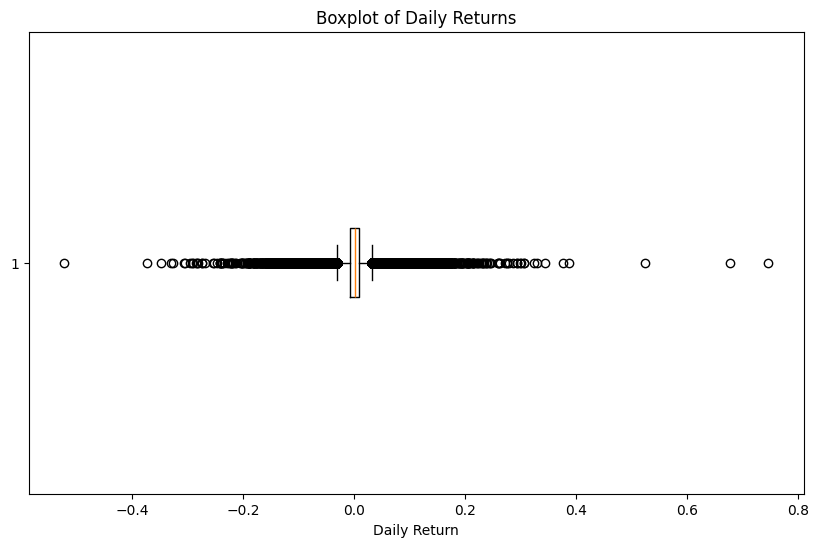

In [9]:
# Identify outliers or extreme data points in returns
plt.figure(figsize=(10, 6))
plt.boxplot(financial_data['Return'].dropna(), vert=False)
plt.title('Boxplot of Daily Returns')
plt.xlabel('Daily Return')
plt.show()

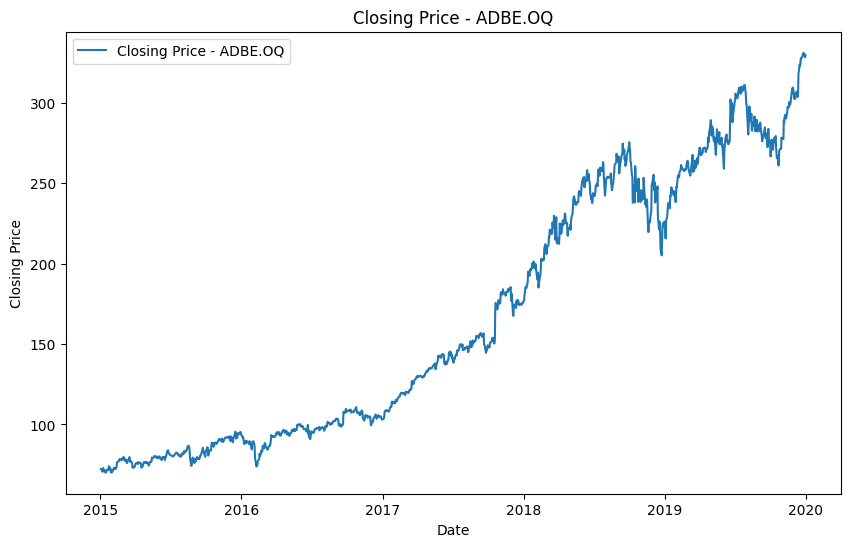

In [10]:
# Select data for a specific company
company_data = financial_data[financial_data['RIC'] == 'ADBE.OQ']

# Line plot for closing price
plt.figure(figsize=(10, 6))
plt.plot(company_data['DATE'], company_data['TRDPRC_1'], label='Closing Price - ADBE.OQ')
plt.title('Closing Price - ADBE.OQ')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

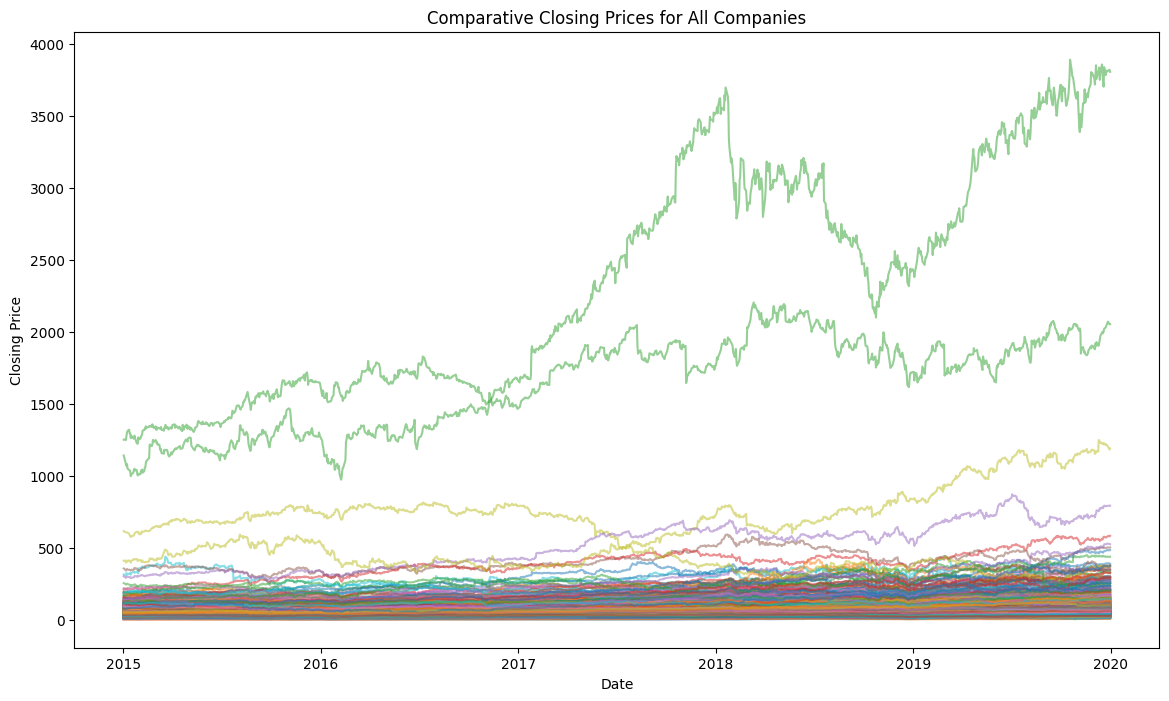

In [11]:
# Plot closing prices for all companies in the dataset
plt.figure(figsize=(14, 8))
for ric in financial_data['RIC'].unique():
    subset = financial_data[financial_data['RIC'] == ric]
    plt.plot(subset['DATE'], subset['TRDPRC_1'], label=ric, alpha=0.5)

plt.title('Comparative Closing Prices for All Companies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
# plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

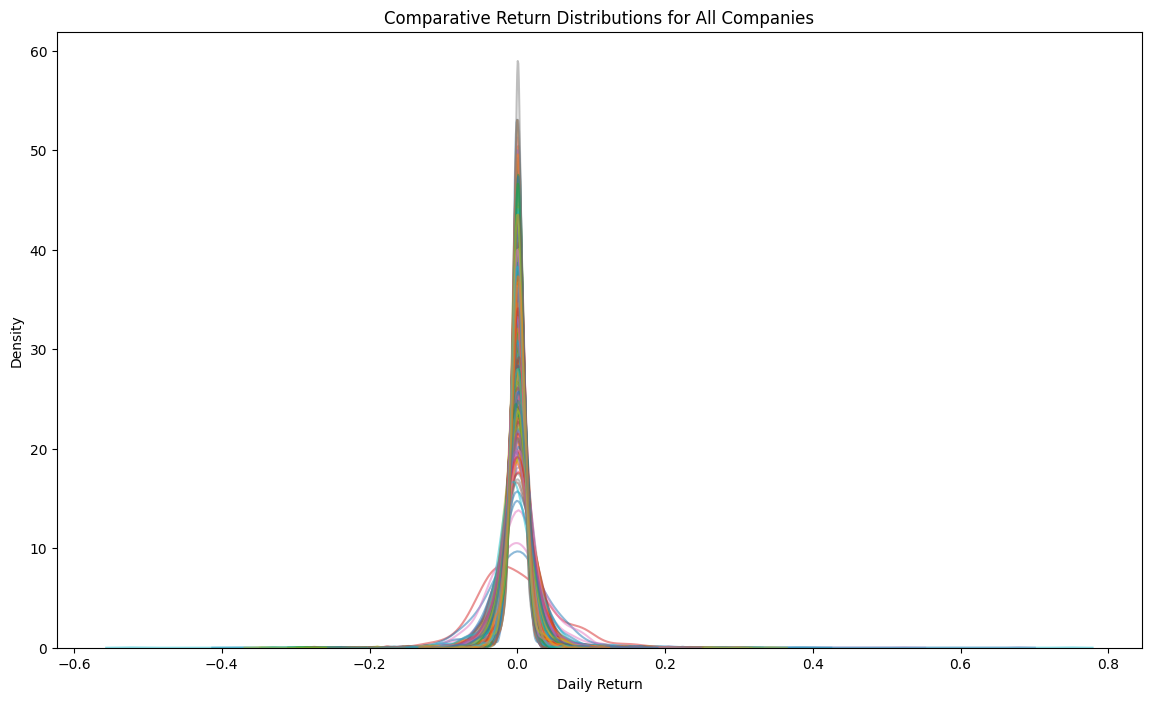

In [12]:
# Plot KDEs of returns for all companies
plt.figure(figsize=(14, 8))
for ric in financial_data['RIC'].unique():
    subset = financial_data[financial_data['RIC'] == ric]
    sns.kdeplot(subset['Return'].dropna(), label=ric, alpha=0.5)

plt.title('Comparative Return Distributions for All Companies')
plt.xlabel('Daily Return')
plt.ylabel('Density')
# plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

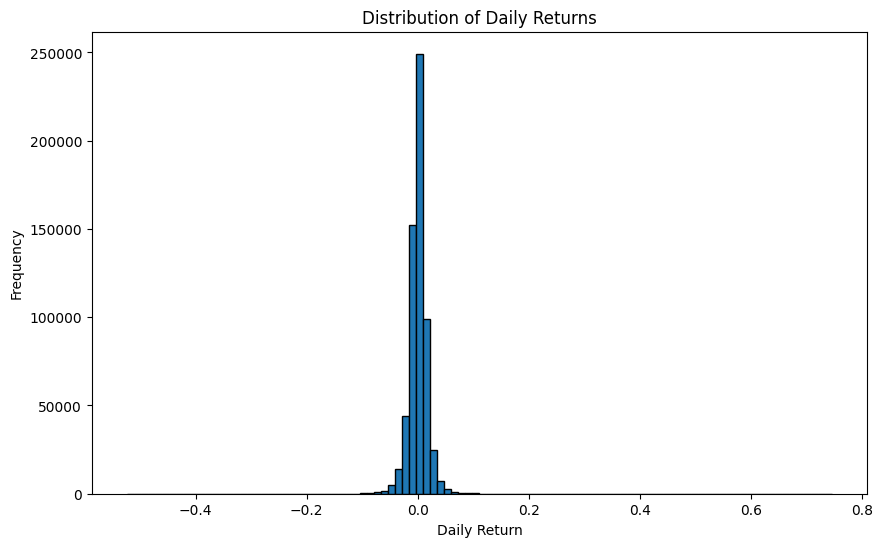

In [13]:
# Histogram to visualize the distribution of daily returns
plt.figure(figsize=(10, 6))
plt.hist(financial_data['Return'].dropna(), bins=100, edgecolor='k')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

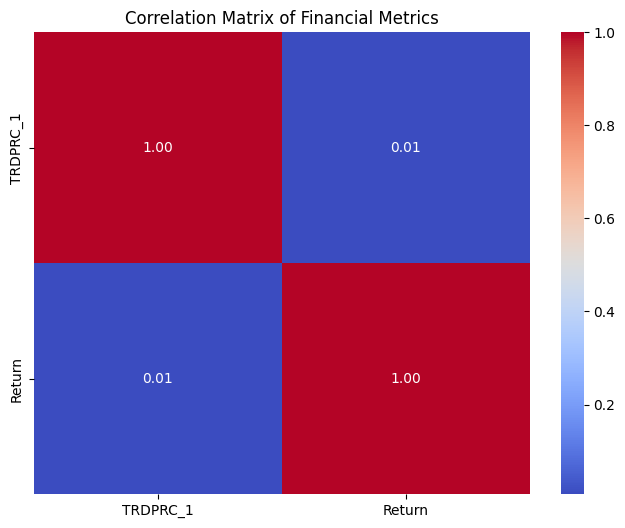

In [14]:
# Calculate correlation matrix
correlation_matrix = financial_data[['TRDPRC_1', 'Return']].corr()

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Financial Metrics')
plt.show()

/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_43586/3262049083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['30_day_MA'] = company_data['TRDPRC_1'].rolling(window=30).mean()


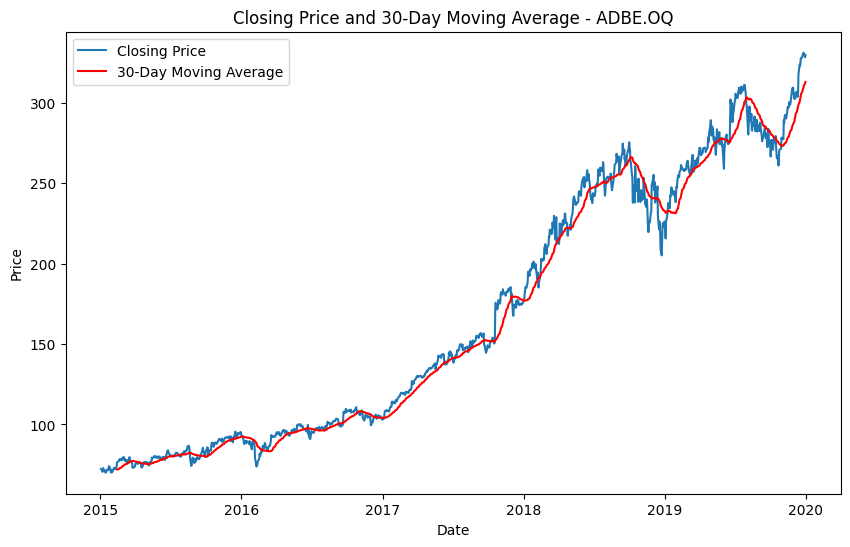

In [15]:
# Calculate the 30-day moving average of the closing prices
company_data['30_day_MA'] = company_data['TRDPRC_1'].rolling(window=30).mean()

# Plot closing prices with moving averages
plt.figure(figsize=(10, 6))
plt.plot(company_data['DATE'], company_data['TRDPRC_1'], label='Closing Price')
plt.plot(company_data['DATE'], company_data['30_day_MA'], label='30-Day Moving Average', color='red')
plt.title('Closing Price and 30-Day Moving Average - ADBE.OQ')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_43586/209420156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Rolling_Std'] = company_data['Return'].rolling(window=30).std()


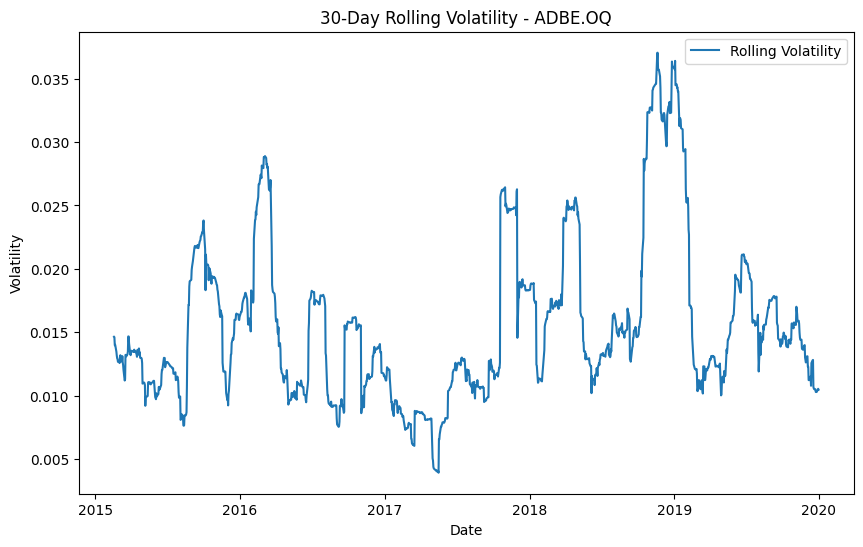

In [16]:
# Calculate rolling standard deviation for returns
company_data['Rolling_Std'] = company_data['Return'].rolling(window=30).std()

# Plot rolling standard deviation
plt.figure(figsize=(10, 6))
plt.plot(company_data['DATE'], company_data['Rolling_Std'], label='Rolling Volatility')
plt.title('30-Day Rolling Volatility - ADBE.OQ')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_43586/2187163353.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Rolling_Std'] = subset['Return'].rolling(window=30).std()
/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_43586/2187163353.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Rolling_Std'] = subset['Return'].rolling(window=30).std()
/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_43586/2187163353.py:5: SettingWithCopyWarning: 
A value is trying

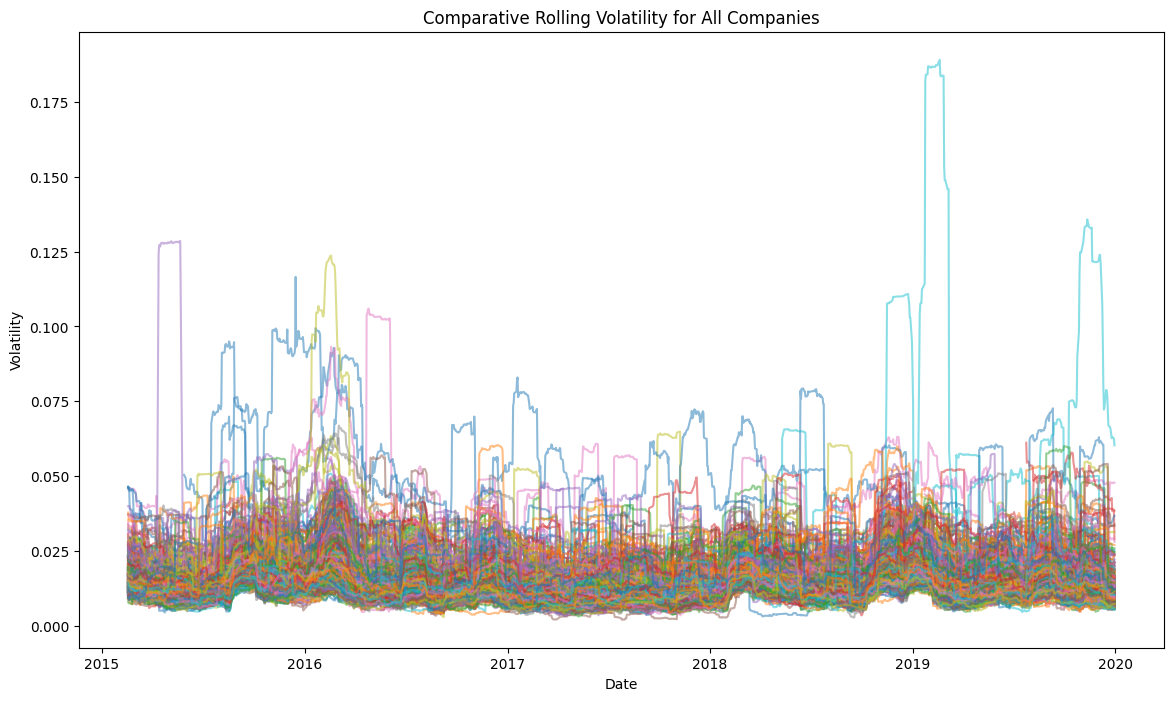

In [17]:
# Calculate and plot rolling volatility for all companies
plt.figure(figsize=(14, 8))
for ric in financial_data['RIC'].unique():
    subset = financial_data[financial_data['RIC'] == ric]
    subset['Rolling_Std'] = subset['Return'].rolling(window=30).std()
    plt.plot(subset['DATE'], subset['Rolling_Std'], label=ric, alpha=0.5)

plt.title('Comparative Rolling Volatility for All Companies')
plt.xlabel('Date')
plt.ylabel('Volatility')
# plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

---

### ESG Data

In [18]:
file_path = 'ESG_Data.xlsx'
data_esg = pd.read_excel(file_path, header=[0, 1])
data_esg.columns = [f'{i} {j}' if j.startswith('FY') else i for i, j in data_esg.columns]

In [19]:
data_esg.head()

,Identifier (RIC),Company Name,Date FY0,Date FY-1,Date FY-2,Date FY-3,Date FY-4,Date FY-5,Date FY-6,Date FY-7,...,Environmental Pillar Score FY0,Environmental Pillar Score FY-1,Environmental Pillar Score FY-2,Environmental Pillar Score FY-3,Environmental Pillar Score FY-4,Environmental Pillar Score FY-5,Environmental Pillar Score FY-6,Environmental Pillar Score FY-7,Environmental Pillar Score FY-8,Environmental Pillar Score FY-9
0,AFL.N,Aflac Inc,2022-12-31,2021-12-31,2020-12-31,2019-12-31,2018-12-31,2017-12-31,2016-12-31,2015-12-31,...,36.215081,35.652374,36.012289,36.366921,30.776712,50.388528,49.090167,51.714961,53.274291,51.420958
1,AES.N,AES Corp,2022-12-31,2021-12-31,2020-12-31,2019-12-31,2018-12-31,2017-12-31,2016-12-31,2015-12-31,...,60.05522,56.464902,54.335468,53.252552,43.316215,33.880078,44.527735,44.186518,37.530089,31.559620
2,ABT.N,Abbott Laboratories,2022-12-31,2021-12-31,2020-12-31,2019-12-31,2018-12-31,2017-12-31,2016-12-31,2015-12-31,...,78.733075,77.082418,76.990459,74.532648,75.433131,75.011161,58.257135,56.598361,50.231026,52.401717
3,ADBE.OQ,Adobe Inc,2022-12-02,2021-12-03,2020-11-27,2019-11-29,2018-11-30,2017-12-01,2016-12-02,2015-11-27,...,76.210632,76.685611,76.599227,76.512331,74.228628,72.329003,80.195468,79.851533,79.932762,81.779554
4,AMD.OQ,Advanced Micro Devices Inc,2022-12-31,2021-12-25,2020-12-26,2019-12-28,2018-12-29,2017-12-30,2016-12-31,2015-12-26,...,70.595561,71.157515,65.916365,65.754214,64.674091,66.558525,67.020375,66.664986,68.335123,66.989599


In [20]:
# Define identifiers and date variables
id_vars = ['Identifier (RIC)', 'Company Name']
date_vars = [col for col in data_esg.columns if 'Date' in col]
metric_vars = [col for col in data_esg.columns if col not in id_vars and not any(c in col for c in date_vars)]

# Melting the DataFrame to include metric and date variables
full_melt = pd.melt(data_esg, id_vars=id_vars, value_vars=metric_vars + date_vars, var_name='Metric FY', value_name='Value')
full_melt[['Metric', 'FY']] = full_melt['Metric FY'].str.rsplit(' ', n=1, expand=True)

# Pivoting the table to have one row per RIC per FY with metrics and date values
final_esg_data = full_melt.pivot_table(index=['Identifier (RIC)', 'Company Name', 'FY'], columns='Metric', values='Value', aggfunc='first').reset_index()

In [21]:
final_esg_data.head()

Metric,Identifier (RIC),Company Name,FY,Date,ESG Combined Score\nIn the last 10 FY,ESG Controversies Score\nIn the last 10 FY,ESG Score\nIn the last 10 FY,Environmental Pillar Score,Governance Pillar Score,Social Pillar Score\nIn the last 10 FY
0,A.N,Agilent Technologies Inc,FY-1,2021-10-31 00:00:00,87.717246,100.0,87.717246,80.001832,86.81275,91.138783
1,A.N,Agilent Technologies Inc,FY-2,2020-10-31 00:00:00,86.602123,100.0,86.602123,79.443412,80.809813,93.53861
2,A.N,Agilent Technologies Inc,FY-3,2019-10-31 00:00:00,87.857831,100.0,87.857831,79.73914,83.400439,94.120704
3,A.N,Agilent Technologies Inc,FY-4,2018-10-31 00:00:00,84.626311,80.0,89.252622,78.196049,88.158126,94.00267
4,A.N,Agilent Technologies Inc,FY-5,2017-10-31 00:00:00,87.612262,100.0,87.612262,77.109375,85.373366,93.035231


In [22]:
final_esg_data.to_csv('transformed_esg_data.csv', index=False)

In [23]:
final_esg_data.columns

Index(['Identifier (RIC)', 'Company Name', 'FY', 'Date',
       'ESG Combined Score\nIn the last 10 FY',
       'ESG Controversies Score\nIn the last 10 FY',
       'ESG Score\nIn the last 10 FY', 'Environmental Pillar Score',
       'Governance Pillar Score', 'Social Pillar Score\nIn the last 10 FY'],
      dtype='object', name='Metric')

In [24]:
# Check for missing values
print("Missing values in each column:")
final_esg_data.isnull().sum()


Missing values in each column:


Metric
Identifier (RIC)                                0
Company Name                                    0
FY                                              0
Date                                           10
ESG Combined Score\nIn the last 10 FY         208
ESG Controversies Score\nIn the last 10 FY    208
ESG Score\nIn the last 10 FY                  208
Environmental Pillar Score                    208
Governance Pillar Score                       208
Social Pillar Score\nIn the last 10 FY        208
dtype: int64

In [25]:
# Descriptive statistics for ESG scores
final_esg_data.describe()

/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_43586/868862566.py:2: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  final_esg_data.describe()


Metric,Identifier (RIC),Company Name,FY,Date,ESG Combined Score\nIn the last 10 FY,ESG Controversies Score\nIn the last 10 FY,ESG Score\nIn the last 10 FY,Environmental Pillar Score,Governance Pillar Score,Social Pillar Score\nIn the last 10 FY
count,4990,4990,4990,4980,4782.000000,4782.0,4782.000000,4782.0,4782.0,4782.000000
unique,499,496,10,382,4757.000000,725.0,4757.000000,4468.0,4733.0,4756.000000
top,A.N,News Corp,FY-1,2016-12-31 00:00:00,36.397971,100.0,57.578551,0.0,50.0,44.596885
freq,10,20,499,372,2.000000,2938.0,2.000000,239.0,13.0,2.000000


In [26]:
# Check unique values in the ESG score columns
print("Unique values in Environmental Pillar Score:", final_esg_data['Environmental Pillar Score'].unique())
print("Unique values in Social Pillar Score:", final_esg_data['Social Pillar Score\nIn the last 10 FY'].unique())
print("Unique values in Governance Pillar Score:", final_esg_data['Governance Pillar Score'].unique())

# Check for missing values in the ESG score columns
print("Missing values in Environmental Pillar Score:", final_esg_data['Environmental Pillar Score'].isnull().sum())
print("Missing values in Social Pillar Score:", final_esg_data['Social Pillar Score\nIn the last 10 FY'].isnull().sum())
print("Missing values in Governance Pillar Score:", final_esg_data['Governance Pillar Score'].isnull().sum())

Unique values in Environmental Pillar Score: [80.0018315018315 79.443412248806 79.7391397503883 ... 25.9785733844469
 20.82761237173 67.3122949237598]
Unique values in Social Pillar Score: [91.1387833099109 93.5386095263021 94.1207036290152 ... 45.2467811059503
 38.52429414379 73.8238633274929]
Unique values in Governance Pillar Score: [86.8127496198654 80.8098132149719 83.4004393009938 ... 28.9442887632795
 31.8070590055119 69.4810841026282]
Missing values in Environmental Pillar Score: 208
Missing values in Social Pillar Score: 208
Missing values in Governance Pillar Score: 208


In [27]:
# Check data types of the ESG score columns
print("Data type of Environmental Pillar Score:", final_esg_data['Environmental Pillar Score'].dtype)
print("Data type of Social Pillar Score:", final_esg_data['Social Pillar Score\nIn the last 10 FY'].dtype)
print("Data type of Governance Pillar Score:", final_esg_data['Governance Pillar Score'].dtype)

Data type of Environmental Pillar Score: object
Data type of Social Pillar Score: object
Data type of Governance Pillar Score: object


In [28]:
# Convert ESG score columns to numeric types
final_esg_data['Environmental Pillar Score'] = pd.to_numeric(final_esg_data['Environmental Pillar Score'], errors='coerce')
final_esg_data['Social Pillar Score\nIn the last 10 FY'] = pd.to_numeric(final_esg_data['Social Pillar Score\nIn the last 10 FY'], errors='coerce')
final_esg_data['Governance Pillar Score'] = pd.to_numeric(final_esg_data['Governance Pillar Score'], errors='coerce')

In [29]:
# Handling missing values by dropping them (you could also consider filling them)
final_esg_data.dropna(subset=['Environmental Pillar Score', 'Social Pillar Score\nIn the last 10 FY', 'Governance Pillar Score'], inplace=True)

In [30]:
# Recheck missing values count to confirm
print("Missing values after cleaning:")
print(final_esg_data[['Environmental Pillar Score', 'Social Pillar Score\nIn the last 10 FY', 'Governance Pillar Score']].isnull().sum())

Missing values after cleaning:
Metric
Environmental Pillar Score                0
Social Pillar Score\nIn the last 10 FY    0
Governance Pillar Score                   0
dtype: int64


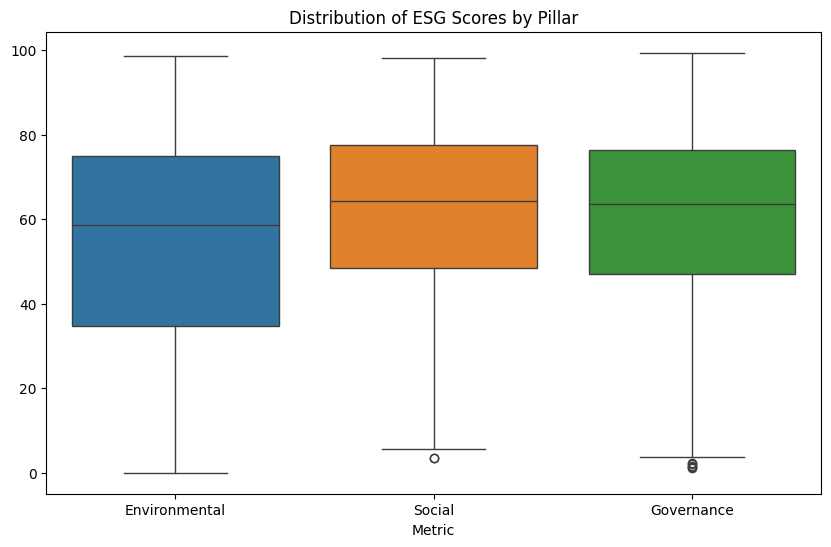

In [31]:
# Replotting the box plots for ESG scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_esg_data[['Environmental Pillar Score', 'Social Pillar Score\nIn the last 10 FY', 'Governance Pillar Score']])
plt.title('Distribution of ESG Scores by Pillar')
plt.xticks([0, 1, 2], ['Environmental', 'Social', 'Governance'])  # Adding custom x-tick labels for clarity
plt.show()

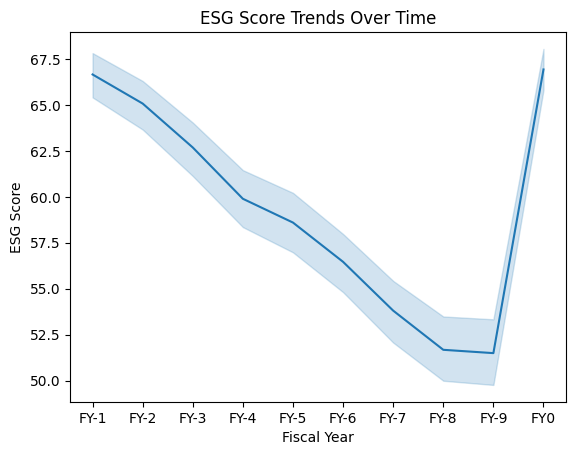

In [32]:
# Example visualization of ESG Score trends over time
sns.lineplot(data=final_esg_data, x='FY', y='ESG Score\nIn the last 10 FY')
plt.title('ESG Score Trends Over Time')
plt.xlabel('Fiscal Year')
plt.ylabel('ESG Score')
plt.show()

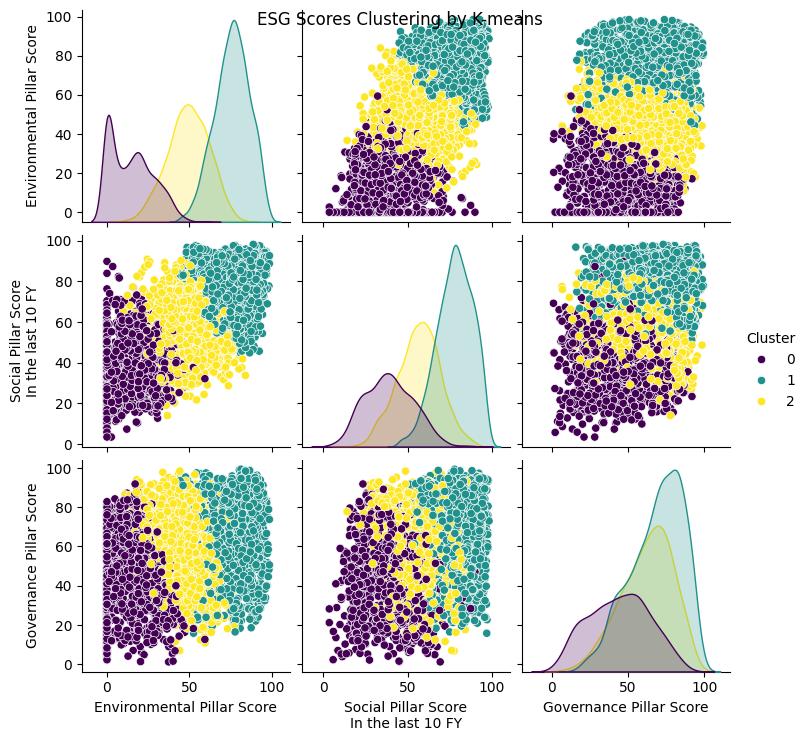

In [33]:
# Preparing data for clustering
esg_features = final_esg_data[['Environmental Pillar Score', 'Social Pillar Score\nIn the last 10 FY', 'Governance Pillar Score']]

# Perform K-means clustering (let's choose 3 clusters as an example)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(esg_features)

# Add cluster information back to the DataFrame
final_esg_data['Cluster'] = clusters

# Plotting the results of clustering
sns.pairplot(final_esg_data, hue='Cluster', vars=['Environmental Pillar Score', 'Social Pillar Score\nIn the last 10 FY', 'Governance Pillar Score'], palette='viridis')
plt.suptitle('ESG Scores Clustering by K-means', verticalalignment='top')
plt.show()

In [34]:
def fy_sort_key(fy):
    # This function extracts the year number from a fiscal year string and handles sorting
    try:
        # Remove 'FY' and then convert the remaining part to an integer
        fy_number = fy.replace('FY', '')
        # Handling negative years (e.g., 'FY-1')
        if '-' in fy_number:
            return -int(fy_number.replace('-', ''))
        return int(fy_number)
    except ValueError:
        # If there's an error (e.g., empty string or non-numeric characters), return a high value to sort last
        return float('inf')

# First, extract all FY columns and sort them
fy_columns = [col for col in final_esg_data.columns if 'FY' in col]
fy_columns_sorted = sorted(fy_columns, key=fy_sort_key, reverse=True)

# Now include other columns that are not FY related
other_columns = [col for col in final_esg_data.columns if col not in fy_columns]
final_columns_order = other_columns + fy_columns_sorted

# Reorder the DataFrame
final_esg_data = final_esg_data[final_columns_order]

# Show the first few rows to verify the new order
final_esg_data.head()

Metric,Identifier (RIC),Company Name,Date,Environmental Pillar Score,Governance Pillar Score,Cluster,FY,ESG Combined Score\nIn the last 10 FY,ESG Controversies Score\nIn the last 10 FY,ESG Score\nIn the last 10 FY,Social Pillar Score\nIn the last 10 FY
0,A.N,Agilent Technologies Inc,2021-10-31 00:00:00,80.001832,86.812750,1,FY-1,87.717246,100.0,87.717246,91.138783
1,A.N,Agilent Technologies Inc,2020-10-31 00:00:00,79.443412,80.809813,1,FY-2,86.602123,100.0,86.602123,93.538610
2,A.N,Agilent Technologies Inc,2019-10-31 00:00:00,79.739140,83.400439,1,FY-3,87.857831,100.0,87.857831,94.120704
3,A.N,Agilent Technologies Inc,2018-10-31 00:00:00,78.196049,88.158126,1,FY-4,84.626311,80.0,89.252622,94.002670
4,A.N,Agilent Technologies Inc,2017-10-31 00:00:00,77.109375,85.373366,1,FY-5,87.612262,100.0,87.612262,93.035231


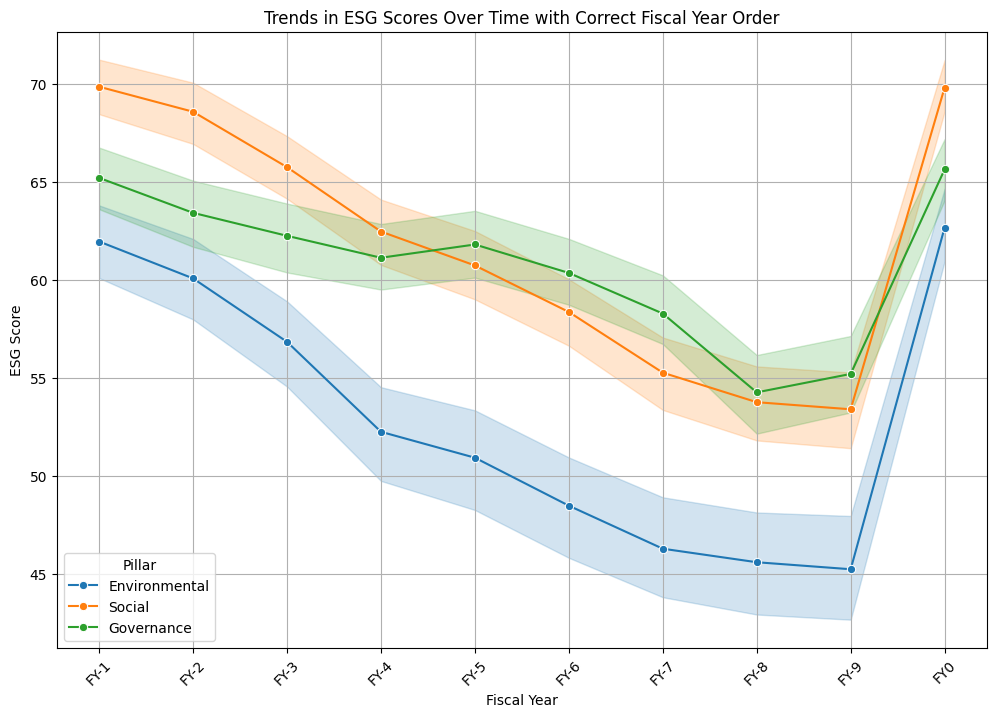

In [35]:
# Assuming that 'FY' and ESG score columns are correctly named and ordered
plt.figure(figsize=(12, 8))
sns.lineplot(data=final_esg_data, x='FY', y='Environmental Pillar Score', marker='o', label='Environmental')
sns.lineplot(data=final_esg_data, x='FY', y='Social Pillar Score\nIn the last 10 FY', marker='o', label='Social')
sns.lineplot(data=final_esg_data, x='FY', y='Governance Pillar Score', marker='o', label='Governance')
plt.title('Trends in ESG Scores Over Time with Correct Fiscal Year Order')
plt.xlabel('Fiscal Year')
plt.ylabel('ESG Score')
plt.legend(title='Pillar')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

### News Data

In [36]:
file_path = 'news.csv'
news_data = pd.read_csv(file_path)

/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_43586/494155493.py:2: DtypeWarning: Columns (2,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  news_data = pd.read_csv(file_path)


In [37]:
# Initial inspection: show the first few rows of the dataset
news_data.head()

,Date,Article_title,Stock_symbol,Url,Publisher,Author,Article,Lsa_summary,Luhn_summary,Textrank_summary,Lexrank_summary
0,2020-06-05 06:30:54 UTC,Stocks That Hit 52-Week Highs On Friday,A,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-03 06:45:20 UTC,Stocks That Hit 52-Week Highs On Wednesday,A,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-26 00:30:07 UTC,71 Biggest Movers From Friday,A,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-05-22 08:45:06 UTC,46 Stocks Moving In Friday's Mid-Day Session,A,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-05-22 07:38:59 UTC,B of A Securities Maintains Neutral on Agilent...,A,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Dataset dimensions
print("Dataset dimensions: ", news_data.shape)

Dataset dimensions:  (13057514, 11)


In [39]:
# Data types of each column
print("Data types for each column: ", news_data.dtypes)

Data types for each column:  Date                 object
Article_title        object
Stock_symbol         object
Url                  object
Publisher            object
Author               object
Article              object
Lsa_summary         float64
Luhn_summary        float64
Textrank_summary    float64
Lexrank_summary     float64
dtype: object


In [40]:
# Check for missing values
print("Missing values in each column:")
print("-"*30)
print(news_data.isnull().sum())

Missing values in each column:
------------------------------
Date                       0
Article_title              1
Stock_symbol         9804627
Url                      686
Publisher            9030871
Author              11871199
Article             11809202
Lsa_summary         13057514
Luhn_summary        13057514
Textrank_summary    13057514
Lexrank_summary     13057514
dtype: int64


In [41]:
# Rimuovere le colonne vuote e inutili
news_data_cleaned = news_data.drop(columns=['Lsa_summary', 'Luhn_summary', 'Textrank_summary', 'Lexrank_summary'])

In [42]:
# Rimuovere le righe con valori mancanti nelle colonne chiave (Stock_symbol e Article_title)
news_data_cleaned = news_data_cleaned.dropna(subset=['Stock_symbol', 'Article_title'])

In [43]:
# Mostrare una sintesi del dataset pulito
print("Dataset cleaned dimensions:", news_data_cleaned.shape)

Dataset cleaned dimensions: (3252887, 7)


In [44]:
# Verifica dei dati mancanti dopo la pulizia
print("Missing values in each column after cleaning:")
print(news_data_cleaned.isnull().sum())

Missing values in each column after cleaning:
Date                   0
Article_title          0
Stock_symbol           0
Url                    0
Publisher              0
Author           3252887
Article          3252887
dtype: int64


In [45]:
# Ridurre il dataset alle sole colonne di interesse
news_data_reduced = news_data_cleaned[['Date', 'Stock_symbol', 'Article_title']]

In [46]:
news_data_reduced.head()

,Date,Stock_symbol,Article_title
0,2020-06-05 06:30:54 UTC,A,Stocks That Hit 52-Week Highs On Friday
1,2020-06-03 06:45:20 UTC,A,Stocks That Hit 52-Week Highs On Wednesday
2,2020-05-26 00:30:07 UTC,A,71 Biggest Movers From Friday
3,2020-05-22 08:45:06 UTC,A,46 Stocks Moving In Friday's Mid-Day Session
4,2020-05-22 07:38:59 UTC,A,B of A Securities Maintains Neutral on Agilent...


In [47]:
print("Reduced dataset dimensions:", news_data_reduced.shape)

Reduced dataset dimensions: (3252887, 3)


In [48]:
# Convertire la colonna 'Date' in formato datetime per una corretta analisi temporale
# news_data_reduced.loc[:, 'Date'] = pd.to_datetime(news_data_reduced['Date'], errors='coerce')
news_data_reduced['Date'] = pd.to_datetime(news_data_reduced['Date'], errors='coerce')

/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_43586/1735382705.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_data_reduced['Date'] = pd.to_datetime(news_data_reduced['Date'], errors='coerce')


In [49]:
# Distribuzione temporale delle notizie per anno
news_by_year = news_data_reduced['Date'].dt.year.value_counts().sort_index()
news_by_year

Date
1969         1
2009     11489
2010     94198
2011    177982
2012    234050
2013    212044
2014    245022
2015    417215
2016    374937
2017    285913
2018    479525
2019    518954
2020    201557
Name: count, dtype: int64

- Il dataset copre principalmente il periodo dal 2009 al 2020, con un picco di notizie tra il 2015 e il 2019. L’anno 2020 ha significativamente meno notizie, probabilmente perché il dataset è incompleto per quell’anno.
- Ci sono pochissime notizie nel 1969, che sembra essere un’anomalia.

In [50]:
news_data_reduced = news_data_reduced[(news_data_reduced['Date'].dt.year >= 2015) & (news_data_reduced['Date'].dt.year <= 2019)]
print("Dataset dimension 2015-2019 period: ", news_data_reduced.shape)

Dataset dimension 2015-2019 period:  (2076544, 3)


In [51]:
# Distribuzione delle notizie per azienda (Stock_symbol)
news_by_symbol = news_data_reduced['Stock_symbol'].value_counts().head(20)
news_by_symbol

Stock_symbol
FCAU    3903
AVGO    3542
YHOO    3523
GXC     3239
KR      3210
MYL     3101
GILD    3067
TWX     3067
PGJ     3031
YINN    3024
FOXA    2924
JD      2892
FDX     2886
FCX     2822
FXP     2820
XPP     2804
WDC     2792
MDT     2781
EWJ     2764
PANW    2754
Name: count, dtype: int64

In [52]:
news_data_reduced

,Date,Stock_symbol,Article_title
70,2019-12-27 00:00:00+00:00,A,Stocks That Hit 52-Week Highs On Friday
71,2019-12-23 00:00:00+00:00,A,Stocks That Hit 52-Week Highs On Monday
72,2019-12-20 00:00:00+00:00,A,Stocks That Hit 52-Week Highs On Friday
73,2019-12-12 00:00:00+00:00,A,Stocks That Hit 52-Week Highs On Thursday
74,2019-12-11 00:00:00+00:00,A,There's A New Trading Tool That Allows Traders...
...,...,...,...
4053840,2015-12-09 00:00:00+00:00,ZX,China Zenix Auto reports Q3 results
4053841,2015-08-19 00:00:00+00:00,ZX,China Zenix's (ZX) CEO Junqiu Gao on Q2 2015 R...
4053842,2015-05-19 00:00:00+00:00,ZX,China Zenix Auto reports Q1 results
4053843,2015-04-17 00:00:00+00:00,ZX,China Zenix Auto's (ZX) Deputy CEO Junqiu Gao ...


In [53]:
# Asegurarse de que 'Date' está en formato datetime
news_data_reduced['Date'] = pd.to_datetime(news_data_reduced['Date'], errors='coerce')

# Limpiar y preparar los títulos de las noticias para el análisis
news_data_reduced['Cleaned_Article_Title'] = news_data_reduced['Article_title'].str.lower().str.replace('[^\w\s]', '', regex=True)

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_43586/3198224762.py:5: SyntaxWarning: invalid escape sequence '\w'
  news_data_reduced['Cleaned_Article_Title'] = news_data_reduced['Article_title'].str.lower().str.replace('[^\w\s]', '', regex=True)


In [54]:
# Descargar lexicon de VADER si es necesario
nltk.download('vader_lexicon')

# Inicializar el analizador de sentimientos VADER
sia = SentimentIntensityAnalyzer()

# Función para obtener el puntaje de sentimiento
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']  # 'compound' es un puntaje que resume el sentimiento

# Aplicar la función a los títulos limpios
news_data_reduced['Sentiment'] = news_data_reduced['Cleaned_Article_Title'].apply(get_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/luca/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


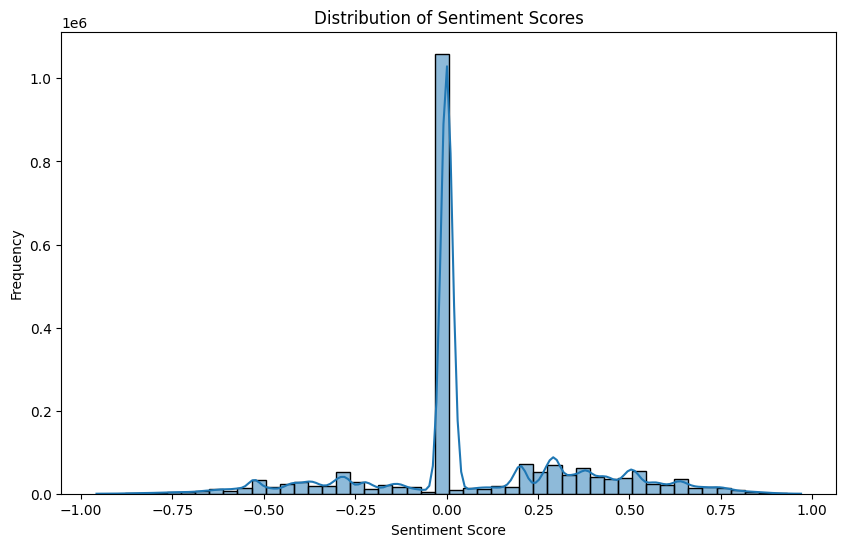

In [55]:
# Plot de la distribución de los puntajes de sentimiento
plt.figure(figsize=(10, 6))
sns.histplot(news_data_reduced['Sentiment'], bins=50, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

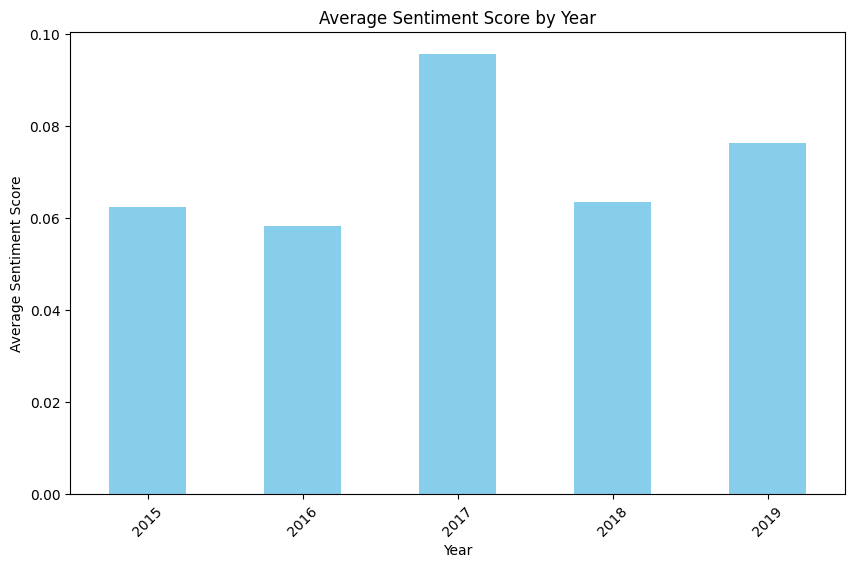

In [56]:
# Plot de sentimiento promedio por año
news_data_reduced['Year'] = news_data_reduced['Date'].dt.year
average_sentiment_per_year = news_data_reduced.groupby('Year')['Sentiment'].mean()

plt.figure(figsize=(10, 6))
average_sentiment_per_year.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score by Year')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()

In [57]:
news_data_reduced.head()

,Date,Stock_symbol,Article_title,Cleaned_Article_Title,Sentiment,Year
70,2019-12-27 00:00:00+00:00,A,Stocks That Hit 52-Week Highs On Friday,stocks that hit 52week highs on friday,0.0,2019
71,2019-12-23 00:00:00+00:00,A,Stocks That Hit 52-Week Highs On Monday,stocks that hit 52week highs on monday,0.0,2019
72,2019-12-20 00:00:00+00:00,A,Stocks That Hit 52-Week Highs On Friday,stocks that hit 52week highs on friday,0.0,2019
73,2019-12-12 00:00:00+00:00,A,Stocks That Hit 52-Week Highs On Thursday,stocks that hit 52week highs on thursday,0.0,2019
74,2019-12-11 00:00:00+00:00,A,There's A New Trading Tool That Allows Traders...,theres a new trading tool that allows traders ...,0.0,2019


## Merging the datasets

In [58]:
# Convertir la columna 'Date' en los datasets ESG y financiero a datetime si aún no está convertida
financial_data['DATE'] = pd.to_datetime(financial_data['DATE'])
final_esg_data['Date'] = pd.to_datetime(final_esg_data['Date'])
news_data_reduced['Date'] = pd.to_datetime(news_data_reduced['Date'])

In [59]:
financial_data['RIC'] = financial_data['RIC'].str.split('.').str[0]
final_esg_data['Identifier (RIC)'] = final_esg_data['Identifier (RIC)'].str.split('.').str[0]

### Financial + News

In [65]:
# Agrupar noticias por fecha y símbolo de acción, concatenar títulos y calcular el promedio del sentimiento
news_grouped = news_data_reduced.groupby(['Date', 'Stock_symbol']).agg({
    'Article_title': lambda x: ' | '.join(x),  # Une los títulos con un separador
    'Sentiment': 'mean'  # Promedio de sentimiento
}).reset_index()

news_grouped.rename(columns={'Article_title': 'Aggregated_Articles', 'Sentiment': 'Average_Sentiment'}, inplace=True)

In [68]:
# Convertir 'Date' a tipo datetime, si no lo está, y eliminar la hora
news_grouped['Date'] = pd.to_datetime(news_grouped['Date']).dt.date
# Convertir nuevamente a datetime para asegurar consistencia en formato de fecha
news_grouped['Date'] = pd.to_datetime(news_grouped['Date'])

In [69]:
news_grouped

,Date,Stock_symbol,Aggregated_Articles,Average_Sentiment
0,2015-01-01,ABX,Update: The Chilean Supreme Court Rules Agains...,0.2787
1,2015-01-01,ACAS,2015 Outlook And Picks,0.0000
2,2015-01-01,ACRX,A Little Impatience And A Lot Of Skepticism Pr...,0.0498
3,2015-01-01,AFL,My K.I.S.S. Dividend Portfolio: 4th Quarter 20...,0.4117
4,2015-01-01,AHT,Dividend Champions For January 2015,0.5267
...,...,...,...,...
1191262,2019-12-31,REFR,Research Frontiers Announces Glatic Has Acquir...,0.4019
1191263,2019-12-31,ELLO,"Ellomay Capital Shares Halted, News Pending",0.2960
1191264,2019-12-31,ELLO,Ellomay Capital Q3 EPS €0.10 Down From €0.12 YoY,0.0000
1191265,2019-12-31,SANW,S&W Seed On Dec. 27 Terminated Credit And Secu...,0.8020


In [70]:
# Suponiendo que financial_data ya está cargado y preparado
# Convertir DATE en financial_data a datetime si aún no lo está
financial_data['DATE'] = pd.to_datetime(financial_data['DATE'])

# Merge financiero y noticias
financial_news_merged = pd.merge(financial_data, news_grouped, how='left', left_on=['DATE', 'RIC'], right_on=['Date', 'Stock_symbol'])

# Eliminar columnas duplicadas de fecha y símbolo de acción después del merge
financial_news_merged.drop(['Date', 'Stock_symbol'], axis=1, inplace=True)

In [76]:
len(financial_news_merged)

604731

In [74]:
# Contar NaNs por columna
nan_counts = financial_news_merged.isna().sum()

# Contar el total de NaNs en todo el DataFrame
total_nans = nan_counts.sum()

print("Número de NaNs por columna:\n", nan_counts)
print("\nTotal de NaNs en el DataFrame:", total_nans)

Número de NaNs por columna:
 DATE                        0
TRDPRC_1                    8
HIGH_1                      8
LOW_1                       8
OPEN_PRC                    8
BID                         4
ASK                         4
TRNOVR_UNS                  8
NUM_MOVES                   5
RIC                         0
Return                    493
Aggregated_Articles    429780
Average_Sentiment      429780
dtype: int64

Total de NaNs en el DataFrame: 860106


In [75]:
# Calcular el total de entradas posibles por columna
total_entries = financial_news_merged.shape[0] * financial_news_merged.shape[1]

# Calcular el porcentaje de NaNs en todo el DataFrame
percentage_nans = (total_nans / total_entries) * 100

print("Porcentaje de NaNs en el DataFrame: {:.2f}%".format(percentage_nans))

Porcentaje de NaNs en el DataFrame: 10.94%


In [78]:
# Calcular el porcentaje de NaNs por columna
percentage_nans_by_column = (nan_counts / financial_news_merged.shape[0]) * 100

print("Porcentaje de NaNs por columna:\n", percentage_nans_by_column)

Porcentaje de NaNs por columna:
 DATE                    0.000000
TRDPRC_1                0.001323
HIGH_1                  0.001323
LOW_1                   0.001323
OPEN_PRC                0.001323
BID                     0.000661
ASK                     0.000661
TRNOVR_UNS              0.001323
NUM_MOVES               0.000827
RIC                     0.000000
Return                  0.081524
Aggregated_Articles    71.069616
Average_Sentiment      71.069616
dtype: float64


In [80]:
# Filtrar los datos donde la columna de noticias agregadas o el sentimiento es NaN
no_news = financial_news_merged[financial_news_merged['Aggregated_Articles'].isna()]

# Obtener los ticker symbols únicos sin noticias
unique_symbols_without_news = no_news['RIC'].unique()

print("Ticker Symbols sin noticias:")
print(unique_symbols_without_news)

Ticker Symbols sin noticias:
['A' 'AAL' 'AAPL' 'ABBV' 'ABT' 'ACGL' 'ACN' 'ADBE' 'ADI' 'ADM' 'ADP'
 'ADSK' 'AEE' 'AEP' 'AES' 'AFL' 'AIG' 'AIZ' 'AJG' 'AKAM' 'ALB' 'ALGN'
 'ALL' 'ALLE' 'AMAT' 'AMCR' 'AMD' 'AME' 'AMGN' 'AMP' 'AMT' 'AMZN' 'ANET'
 'ANSS' 'AON' 'AOS' 'APA' 'APD' 'APH' 'APTV' 'ARE' 'ATO' 'AVB' 'AVGO'
 'AVY' 'AWK' 'AXON' 'AXP' 'AZO' 'BA' 'BAC' 'BALL' 'BAX' 'BBWI' 'BBY' 'BDX'
 'BEN' 'BFb' 'BG' 'BIIB' 'BIO' 'BK' 'BKNG' 'BKR' 'BLDR' 'BLK' 'BMY' 'BR'
 'BRKb' 'BRO' 'BSX' 'BWA' 'BX' 'BXP' 'C' 'CAG' 'CAH' 'CAT' 'CB' 'CBOE'
 'CBRE' 'CCI' 'CCL' 'CDNS' 'CDW' 'CE' 'CF' 'CFG' 'CHD' 'CHRW' 'CHTR' 'CI'
 'CINF' 'CL' 'CLX' 'CMCSA' 'CME' 'CMG' 'CMI' 'CMS' 'CNC' 'CNP' 'COF' 'COO'
 'COP' 'COR' 'COST' 'CPAY' 'CPB' 'CPRT' 'CPT' 'CRL' 'CRM' 'CRWD' 'CSCO'
 'CSGP' 'CSX' 'CTAS' 'CTLT' 'CTRA' 'CTSH' 'CTVA' 'CVS' 'CVX' 'CZR' 'D'
 'DAL' 'DAY' 'DD' 'DE' 'DECK' 'DFS' 'DG' 'DGX' 'DHI' 'DHR' 'DIS' 'DLR'
 'DLTR' 'DOC' 'DOV' 'DOW' 'DPZ' 'DRI' 'DTE' 'DUK' 'DVA' 'DVN' 'DXCM' 'EA'
 'EBAY' 'ECL' 'ED' 'EFX' 'EG' 'EI

In [81]:
# Contar las ocurrencias de cada ticker symbol sin noticias
count_symbols_without_news = no_news['RIC'].value_counts()

print("Conteo de Ticker Symbols sin noticias:")
print(count_symbols_without_news)

Conteo de Ticker Symbols sin noticias:
RIC
IRM     1258
PNW     1258
CZR     1258
SPGI    1258
SNA     1258
        ... 
AMCR     142
CRWD     141
FOX      108
FOXA      81
DOW       63
Name: count, Length: 492, dtype: int64


### Merged (Financial + News) Data + ESG Data

In [83]:
# Crear la columna 'Year' extrayendo el año de 'DATE'
financial_news_merged['Year'] = financial_news_merged['DATE'].dt.year
final_esg_data['Year'] = final_esg_data['Date'].dt.year

In [89]:
financial_news_merged

,DATE,TRDPRC_1,HIGH_1,LOW_1,OPEN_PRC,BID,ASK,TRNOVR_UNS,NUM_MOVES,RIC,Return,Aggregated_Articles,Average_Sentiment,Year
0,2015-01-02,40.56,41.31,40.38,41.18,40.56,40.57,1.469962e+07,1701.0,A,NaN,NaN,NaN,2015
1,2015-01-05,39.80,40.46,39.70,40.32,39.78,39.80,2.073307e+07,2024.0,A,-0.018738,ModernGraham Quarterly Valuation Of Agilent Te...,0.3243,2015
2,2015-01-06,39.18,40.00,39.02,39.81,39.16,39.18,2.642439e+07,2082.0,A,-0.015578,NaN,NaN,2015
3,2015-01-07,39.70,39.81,39.31,39.52,39.69,39.70,2.565600e+07,2955.0,A,0.013272,NaN,NaN,2015
4,2015-01-08,40.89,40.97,40.18,40.28,40.88,40.89,2.436219e+07,2563.0,A,0.029975,NaN,NaN,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604726,2019-12-24,132.92,133.08,131.30,132.21,132.93,132.95,2.226815e+07,1267.0,ZTS,0.004155,NaN,NaN,2019
604727,2019-12-26,133.03,133.19,132.32,133.19,133.03,133.04,5.169614e+07,1846.0,ZTS,0.000828,NaN,NaN,2019
604728,2019-12-27,133.25,133.48,132.42,133.40,133.25,133.26,6.171808e+07,2370.0,ZTS,0.001654,The Zacks Analyst Blog Highlights: Texas Instr...,0.0000,2019
604729,2019-12-30,132.21,133.59,131.88,133.57,132.21,132.24,4.239500e+07,2679.0,ZTS,-0.007805,NaN,NaN,2019


In [90]:
final_esg_data

Metric,Identifier (RIC),Company Name,Date,Environmental Pillar Score,Governance Pillar Score,Cluster,FY,ESG Combined Score\nIn the last 10 FY,ESG Controversies Score\nIn the last 10 FY,ESG Score\nIn the last 10 FY,Social Pillar Score\nIn the last 10 FY,Year
0,A,Agilent Technologies Inc,2021-10-31,80.001832,86.812750,1,FY-1,87.717246,100.0,87.717246,91.138783,2021.0
1,A,Agilent Technologies Inc,2020-10-31,79.443412,80.809813,1,FY-2,86.602123,100.0,86.602123,93.538610,2020.0
2,A,Agilent Technologies Inc,2019-10-31,79.739140,83.400439,1,FY-3,87.857831,100.0,87.857831,94.120704,2019.0
3,A,Agilent Technologies Inc,2018-10-31,78.196049,88.158126,1,FY-4,84.626311,80.0,89.252622,94.002670,2018.0
4,A,Agilent Technologies Inc,2017-10-31,77.109375,85.373366,1,FY-5,87.612262,100.0,87.612262,93.035231,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4985,ZTS,Zoetis Inc,2017-12-31,21.328671,51.389404,0,FY-6,51.539859,100.0,51.539859,66.465356,2017.0
4986,ZTS,Zoetis Inc,2016-12-31,24.096970,45.078984,0,FY-7,45.265223,100.0,45.265223,55.777239,2016.0
4987,ZTS,Zoetis Inc,2015-12-31,25.978573,28.944289,0,FY-8,35.818464,100.0,35.818464,45.246781,2015.0
4988,ZTS,Zoetis Inc,2014-12-31,20.827612,31.807059,0,FY-9,32.422634,100.0,32.422634,38.524294,2014.0


In [91]:
full_merged_data = pd.merge(financial_news_merged, final_esg_data, how='left', left_on=['RIC', 'Year'], right_on=['Identifier (RIC)', 'Year'])
full_merged_data.drop(['Identifier (RIC)', 'Date'], axis=1, inplace=True)

In [94]:
full_merged_data.head()

,DATE,TRDPRC_1,HIGH_1,LOW_1,OPEN_PRC,BID,ASK,TRNOVR_UNS,NUM_MOVES,RIC,...,Year,Company Name,Environmental Pillar Score,Governance Pillar Score,Cluster,FY,ESG Combined Score\nIn the last 10 FY,ESG Controversies Score\nIn the last 10 FY,ESG Score\nIn the last 10 FY,Social Pillar Score\nIn the last 10 FY
0,2015-01-02,40.56,41.31,40.38,41.18,40.56,40.57,1.469962e+07,1701.0,A,...,2015,Agilent Technologies Inc,71.705539,68.513544,1.0,FY-7,78.094941,100.0,78.094941,87.636549
1,2015-01-05,39.80,40.46,39.70,40.32,39.78,39.80,2.073307e+07,2024.0,A,...,2015,Agilent Technologies Inc,71.705539,68.513544,1.0,FY-7,78.094941,100.0,78.094941,87.636549
2,2015-01-06,39.18,40.00,39.02,39.81,39.16,39.18,2.642439e+07,2082.0,A,...,2015,Agilent Technologies Inc,71.705539,68.513544,1.0,FY-7,78.094941,100.0,78.094941,87.636549
3,2015-01-07,39.70,39.81,39.31,39.52,39.69,39.70,2.565600e+07,2955.0,A,...,2015,Agilent Technologies Inc,71.705539,68.513544,1.0,FY-7,78.094941,100.0,78.094941,87.636549
4,2015-01-08,40.89,40.97,40.18,40.28,40.88,40.89,2.436219e+07,2563.0,A,...,2015,Agilent Technologies Inc,71.705539,68.513544,1.0,FY-7,78.094941,100.0,78.094941,87.636549
